#  UNDERSTAND THE PROBLEM STATEMENT

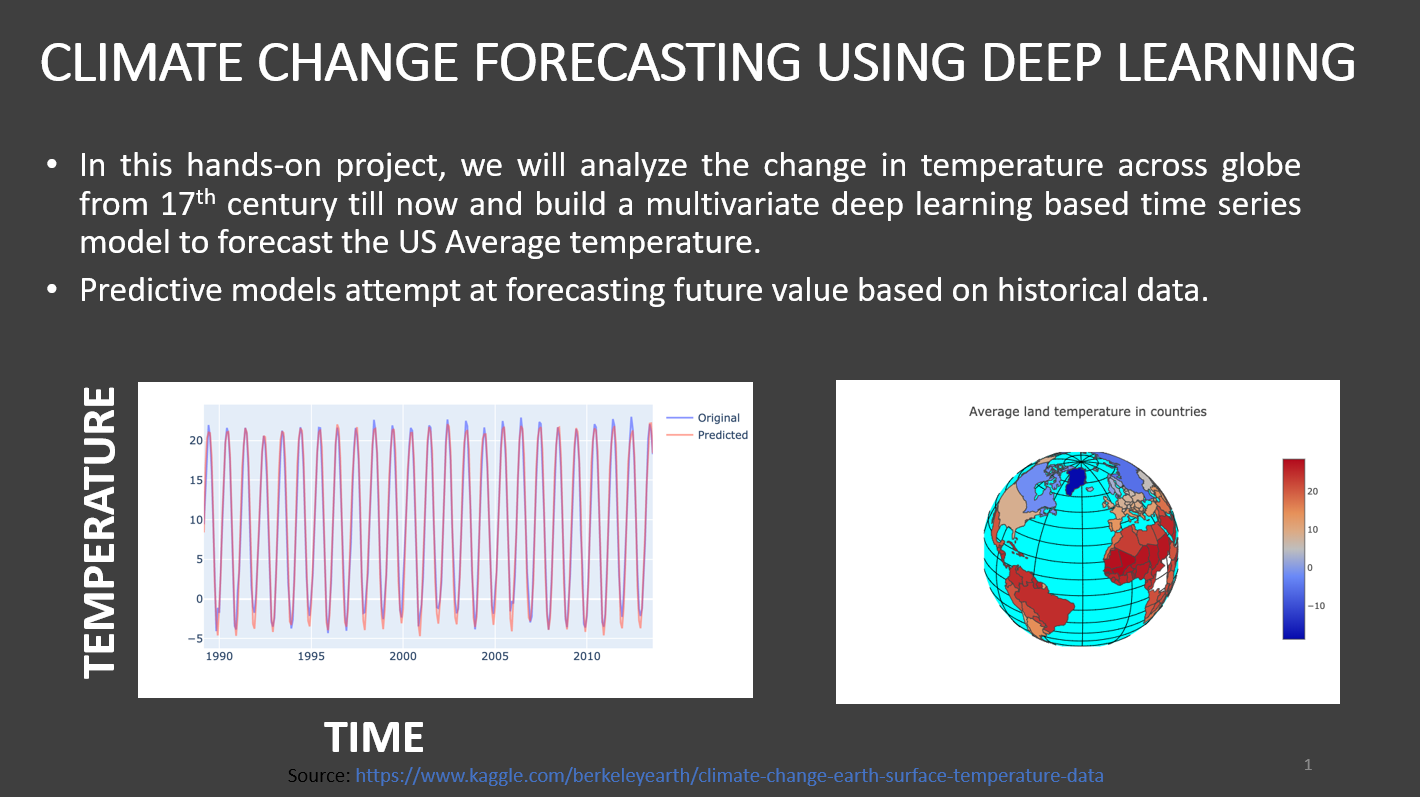

# IMPORT DATASETS AND LIBRARIES

In [ ]:
# import key libraries
import pandas as pd
import plotly.express as px
from copy import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go


In [ ]:
#from jupyterthemes import jtplot
#jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False) 
# setting the style of the notebook to be monokai theme  
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them. 


In [ ]:
# Data Source: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data/notebooks?datasetId=29&sortBy=voteCount

In [ ]:
# Read the files
temperature_df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
# dt: Date on which records were observed
# AverageTemperature : Mean temperature of the country 
# AverageTemperatureUncertinity: Uncertainty associated with recorded temperature 
# Country: Country name


In [ ]:
temperature_df.head()

In [ ]:
temperature_df.tail(10)

In [ ]:
temperature_df.info()

# PERFORM EXPLORATORY DATA ANALYSIS

In [ ]:
# Check the unique countries
temperature_df['Country'].unique()

In [ ]:
# Check for missing values
temperature_df.isnull().sum()

In [ ]:
temperature_df.describe()

# PERFORM DATA CLEANING

In [ ]:
# Do groupby country to see the count of values available for each country
country_group_df = temperature_df.groupby(by = 'Country').count().reset_index('Country').rename(columns={'AverageTemperature':'AverageTemperatureCount','AverageTemperatureUncertainty' : 'AverageTemperatureUncertaintyCount'})

In [ ]:
country_group_df

In [ ]:
country_group_df['Country']

In [ ]:
import plotly.express as px
fig = px.bar(country_group_df, x = 'Country', y = 'AverageTemperatureCount')
fig.show()

In [ ]:
fig = px.bar(country_group_df, x = 'Country', y = 'AverageTemperatureUncertaintyCount')
fig.show()

In [ ]:
# Plot the histogram of AverageTemperatureCount
fig = px.histogram(country_group_df, x = "AverageTemperatureCount")
fig.show()

In [ ]:
# Plot the histogram of AverageTemperatureUncertainityCount
fig = px.histogram(country_group_df, x = "AverageTemperatureUncertaintyCount")
fig.show()

From the histogram above it seems there are entries for which sample size is too small .Hence to make it uniform and remove the outliers we would create a criteria i.e. country would be picked if only average temperature count is >= 1500 

In [ ]:
country_group_df[(country_group_df['AverageTemperatureCount'] < 1500) | (country_group_df['AverageTemperatureUncertaintyCount'] < 1500)]

In [ ]:
# Find the countries that have less than 1500 data points
countries_with_less_data = country_group_df[(country_group_df['AverageTemperatureCount'] < 1500) | (country_group_df['AverageTemperatureUncertaintyCount'] < 1500)].index.tolist()

In [ ]:
countries_with_less_data

In [ ]:
~temperature_df['Country'].isin(countries_with_less_data)

In [ ]:
# Remove the countries with less data points
temperature_df = temperature_df[~temperature_df['Country'].isin(countries_with_less_data)]

In [ ]:
# Reset the index
temperature_df.reset_index(inplace = True, drop = True)

In [ ]:
temperature_df

In [ ]:
# Fill the missing values by doing rolling average on past 730 days
temperature_df['AverageTemperature'] = temperature_df['AverageTemperature'].fillna(temperature_df['AverageTemperature'].rolling(730, min_periods = 1).mean())

In [ ]:
# Fill the missing values by doing rolling average on past 730 days
temperature_df['AverageTemperatureUncertainty']= temperature_df['AverageTemperatureUncertainty'].fillna(temperature_df['AverageTemperatureUncertainty'].rolling(730, min_periods=1).mean())

In [ ]:
temperature_df.isna().sum()

In [ ]:
# Check the unique countries
temperature_df['Country'].unique()

In [ ]:
# Check for the presence of other version of same country
duplicates = []
for i in temperature_df['Country'].unique():
    if '(' in i:
        duplicates.append(i)
duplicates

In [ ]:
# replace the duplicates
temperature_df = temperature_df.replace(duplicates, ['Congo', 'Denmark','Falkland Islands','France','Netherlands','United Kingdom'])

In [ ]:
temperature_df['Country'].unique()

Fill out the missing values by doing rolling average over 365 days

In [ ]:
temperature_df['AverageTemperatureUncertainty']= temperature_df['AverageTemperatureUncertainty'].fillna(temperature_df['AverageTemperatureUncertainty'].rolling(365, min_periods=1).mean())

#  PERFORM DATA VISUALIZATION

In [ ]:
countries = temperature_df['Country'].unique().tolist()
countries

In [ ]:
# Get the mean temperature for each country
mean_temperature = []
for i in countries:
    mean_temperature.append(temperature_df[temperature_df['Country'] == i]['AverageTemperature'].mean())

In [ ]:
# Plot the mean teamperature of countries
data = [ dict(type = 'choropleth', # type of map
              locations = countries, # location names
              z = mean_temperature, # temperature of countries
              locationmode = 'country names')
       ]

layout = dict(title = 'Average Global Land Temperatures',
              geo = dict(showframe = False,
                         showocean = True, # to show the ocean
                         oceancolor = 'aqua',
                         projection = dict(type = 'orthographic'))) # to get the globe view),

fig = dict(data = data, layout = layout)
py.iplot(fig, validate = False, filename = 'worldmap')

In [ ]:
# Get the year of recorded data, for visualization purpose
temperature_df['year'] = temperature_df['dt'].apply(lambda x: x.split('-')[0])
temperature_df

In [ ]:
# To create the animation to see the global temperature change
fig = px.choropleth(temperature_df, locations = 'Country',
                    locationmode = 'country names', # locations 
                    color = 'AverageTemperature', # column representing the temperature
                    hover_name = "Country", # column to add to hover information
                    animation_frame = 'year', # timeframe for animation
                    color_continuous_scale = px.colors.sequential.deep_r)
# py.plot(fig)
fig.show()

In [ ]:
# To get the global average tempeature over years
df_global = temperature_df.groupby('year').mean().reset_index()

In [ ]:
# Convert the year to int type and use the data above 1850 for visualization (Before this most of the countries do not have recorded reading)
df_global['year'] = df_global['year'].apply(lambda x: int(x))
df_global = df_global[df_global['year'] > 1850]

In [ ]:
# Uncertainity upper bound 
trace1 = go.Scatter(
    x = df_global['year'], 
    y = np.array(df_global['AverageTemperature']) + np.array(df_global['AverageTemperatureUncertainty']), # Adding uncertinity
    name = 'Uncertainty top',
    line = dict(color = 'green'))

# Uncertainity lower bound
trace2 = go.Scatter(
    x = df_global['year'] , 
    y = np.array(df_global['AverageTemperature']) - np.array(df_global['AverageTemperatureUncertainty']), # Subtracting uncertinity
    fill = 'tonexty',
    name = 'Uncertainty bottom',
    line = dict(color = 'green'))

# Recorded temperature
trace3 = go.Scatter(
    x = df_global['year'] , 
    y = df_global['AverageTemperature'],
    name = 'Average Temperature',
    line = dict(color='red'))
data = [trace1, trace2, trace3]

layout = go.Layout(
    xaxis = dict(title = 'year'),
    yaxis = dict(title = 'Average Temperature, °C'),
    title = 'Average Land Temperatures Globally',
    showlegend = False)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [ ]:
# We are going to do the modeling for US data
US_df = temperature_df[temperature_df['Country'] == 'United States'].reset_index(drop = True)
US_df

In [ ]:
fig = px.line(title = 'US Temperature Data')
US_df_updated = US_df[US_df['year'] > '1813']
fig.add_scatter(x = US_df_updated['dt'], y = US_df_updated['AverageTemperature'], name = 'US Temperature')
fig.show()

# PERPARE THE DATA TO TRAIN THE MODEL (GLOBAL DATA)

In [ ]:
# Get the month of recording, to use as a feature
temperature_df['Month'] = temperature_df['dt'].apply(lambda x: int(x.split('-')[1]))

In [ ]:
# To get the global average tempeature over years
df_global_monthly = temperature_df.groupby(['dt']).mean().reset_index()

In [ ]:
df_global_monthly

In [ ]:
# Function that creates the data for training the time series model
def prepare_data(df, feature_range):
    # Get the columns
    columns = df.columns
    # For the given range, create lagged input feature for the given columns
    for i in range(1, (feature_range + 1)):
        for j in columns[1:]:
            name = j + '_t-' + str(i)
            df[name] = df[j].shift((i))
    # Create the target by using next value as the target
    df['Target'] = df['AverageTemperature'].shift(-1)
    return df

In [ ]:
# Get the training data
df_global_monthly = prepare_data(df_global_monthly, 3)

In [ ]:
df_global_monthly

In [ ]:
df_global_monthly = df_global_monthly.dropna().reset_index(drop = True)

In [ ]:
df_global_monthly

In [ ]:
# Split the data
train = df_global_monthly[:int(0.9 * len(df_global_monthly))].drop(columns = 'dt').values

In [ ]:
# Split the data
test = df_global_monthly[int(0.9 * len(df_global_monthly)):].drop(columns = 'dt').values

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range = (0, 1))
train  = scaler.fit_transform(train)
test   = scaler.transform(test)

In [ ]:
# Split the data into input features and targets
train_x, train_y = train[:,:-1], train[:,-1]
test_x, test_y = test[:,:-1], test[:,-1]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

# INFORMATION/UNDERSTAND THE INTUITION BEHIND LSTM NETWORKS

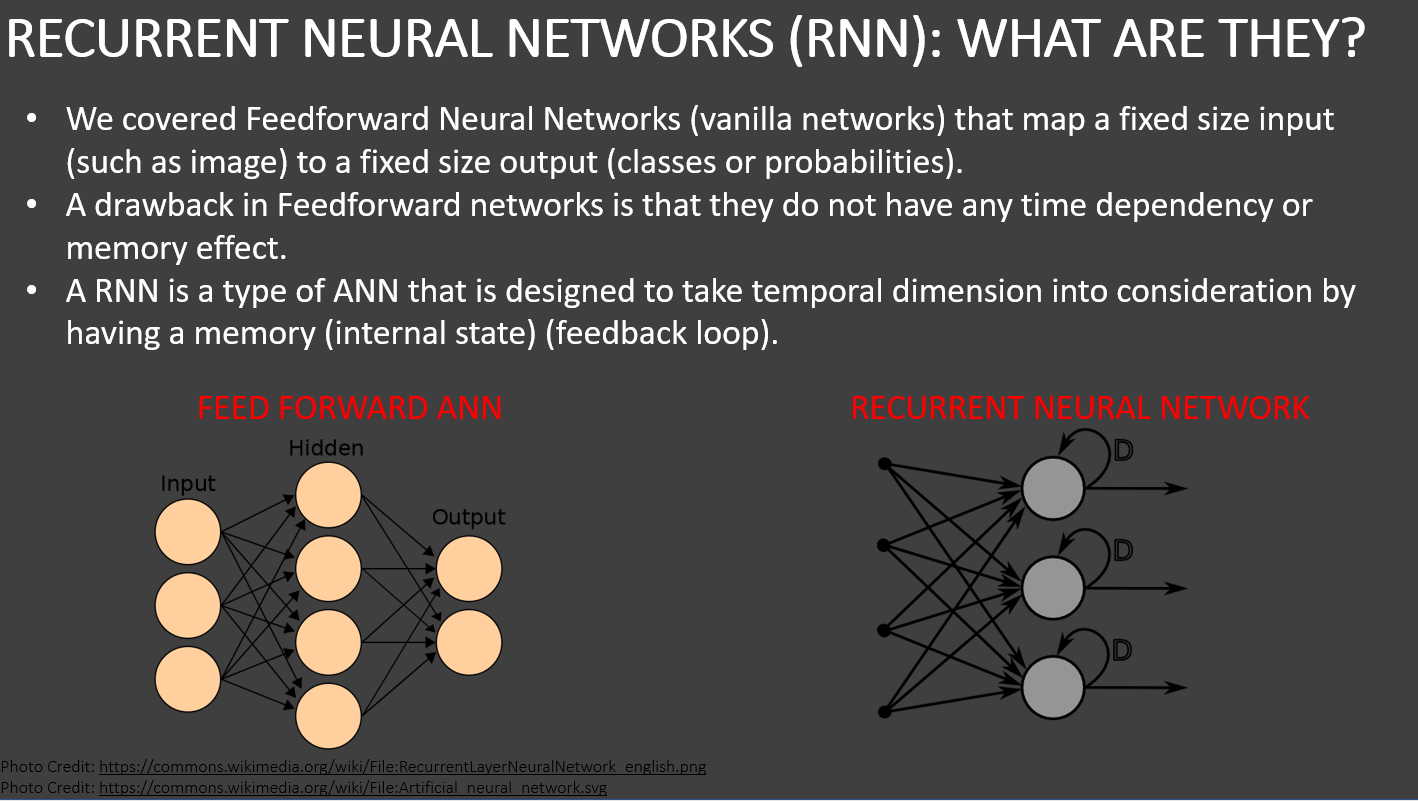

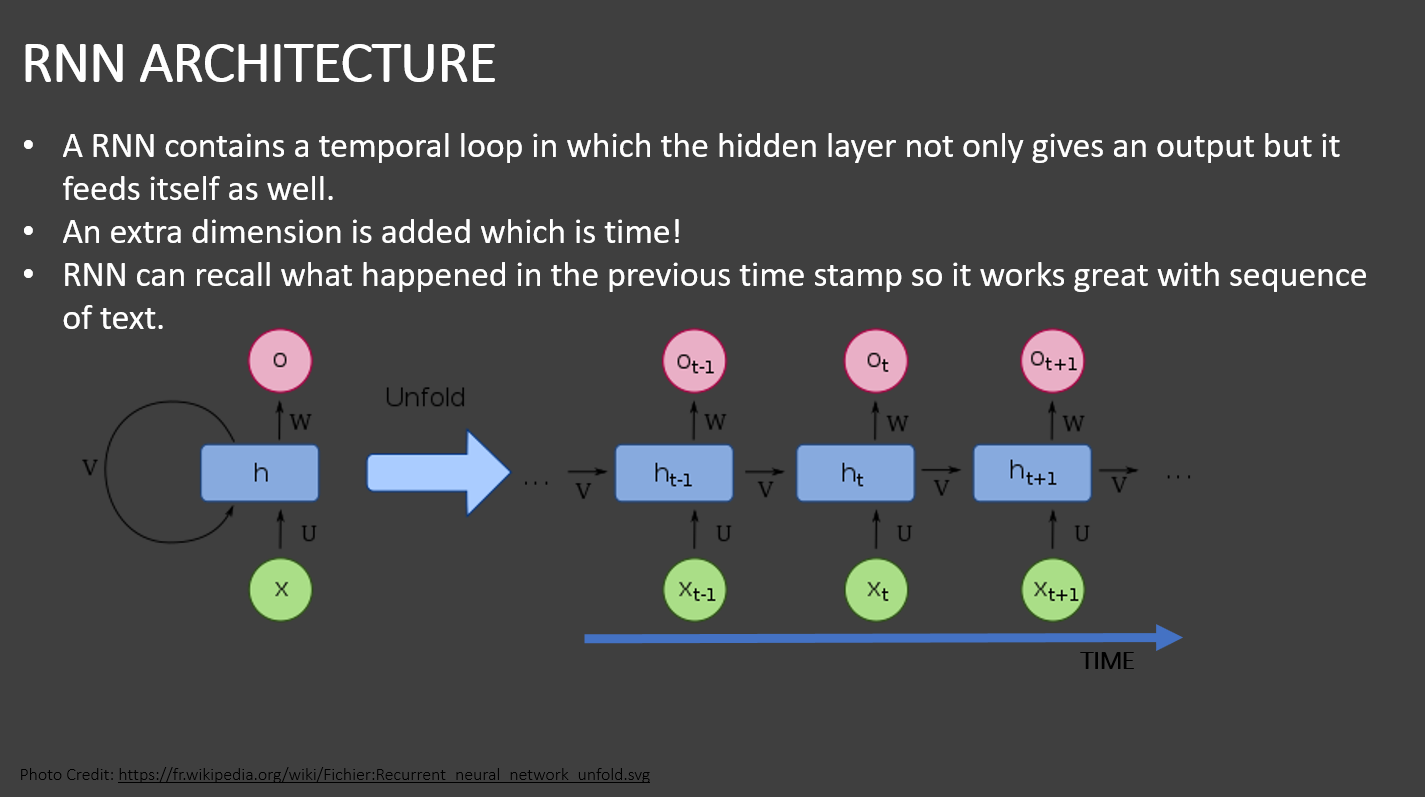

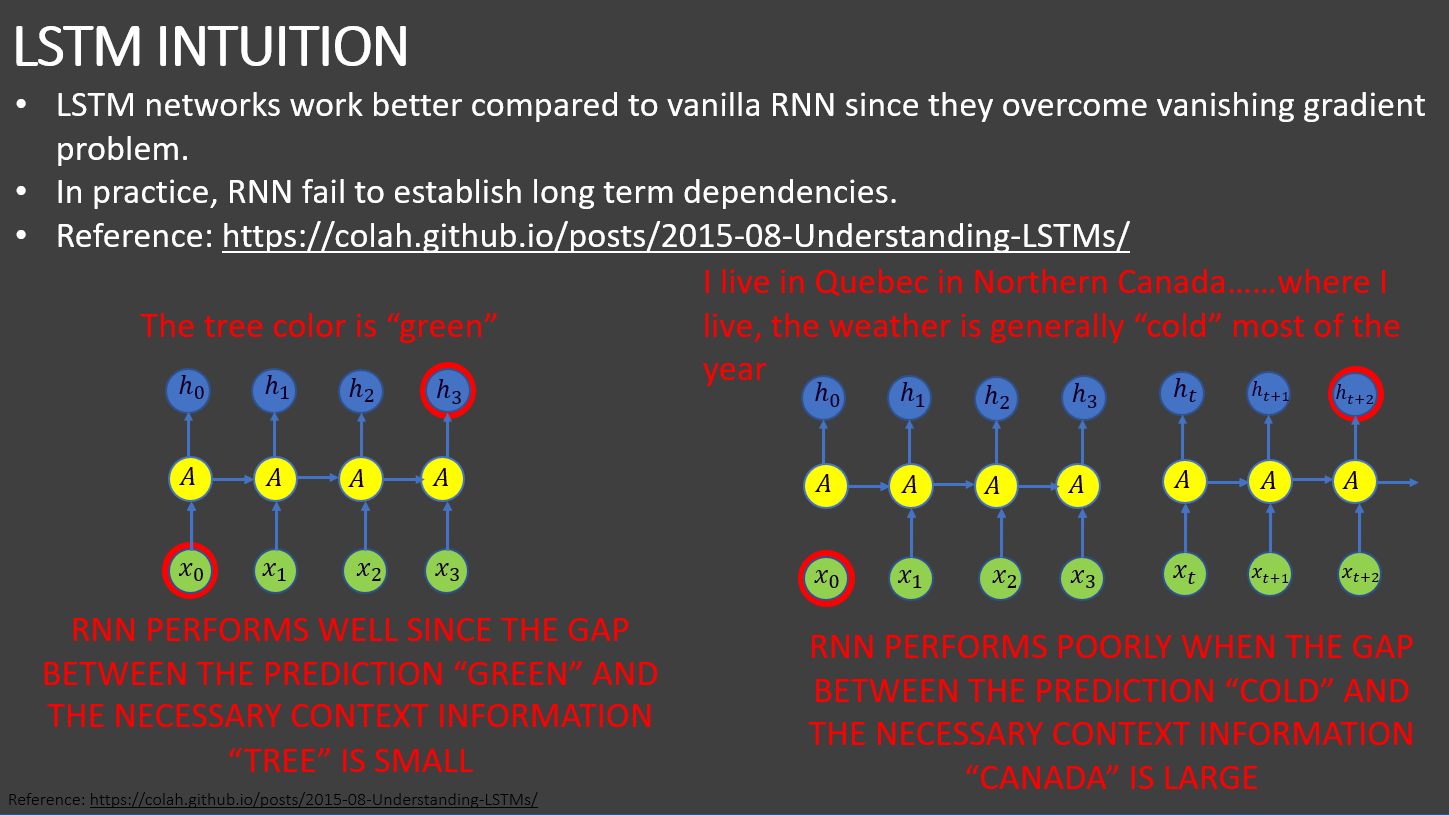

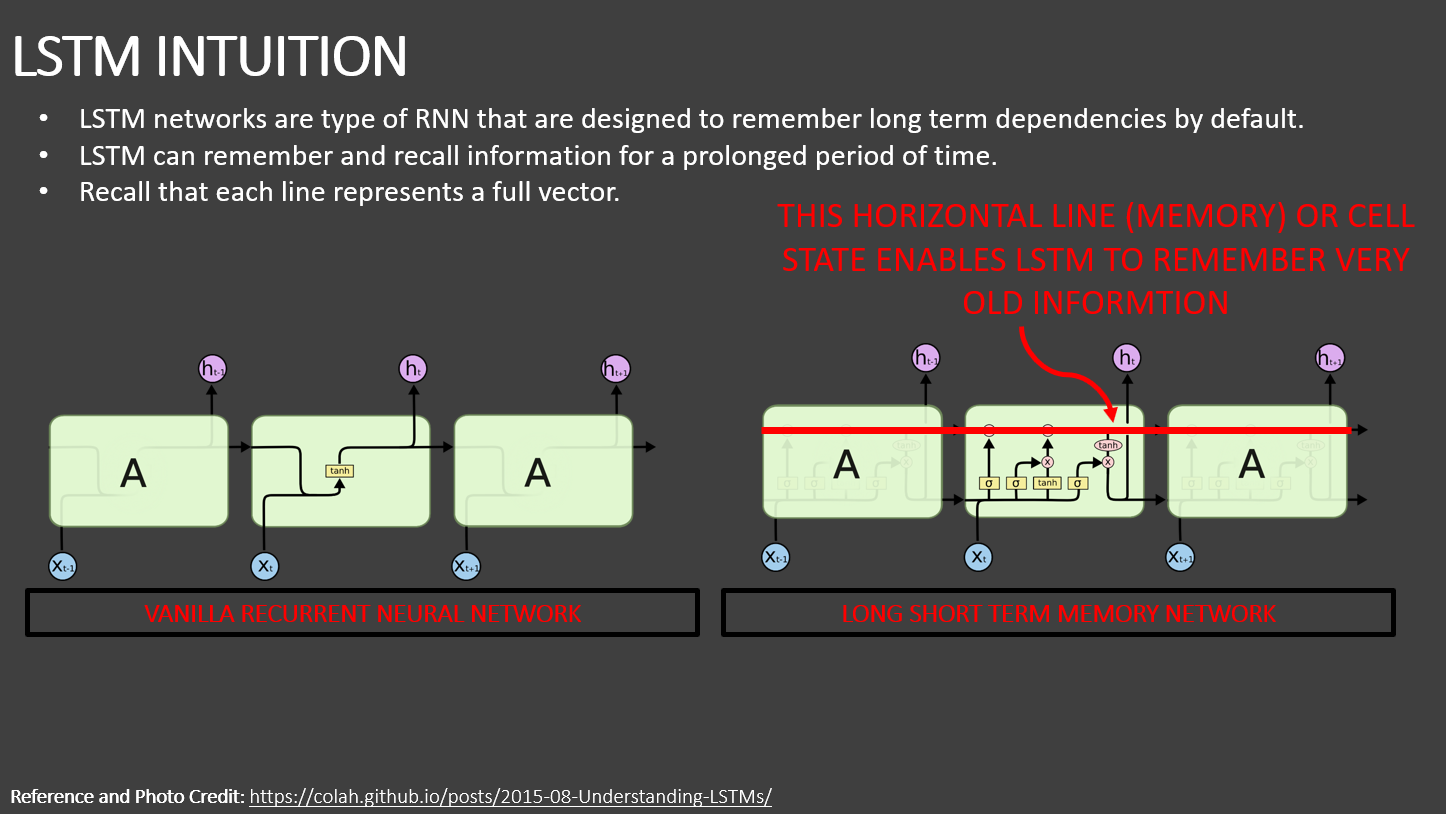

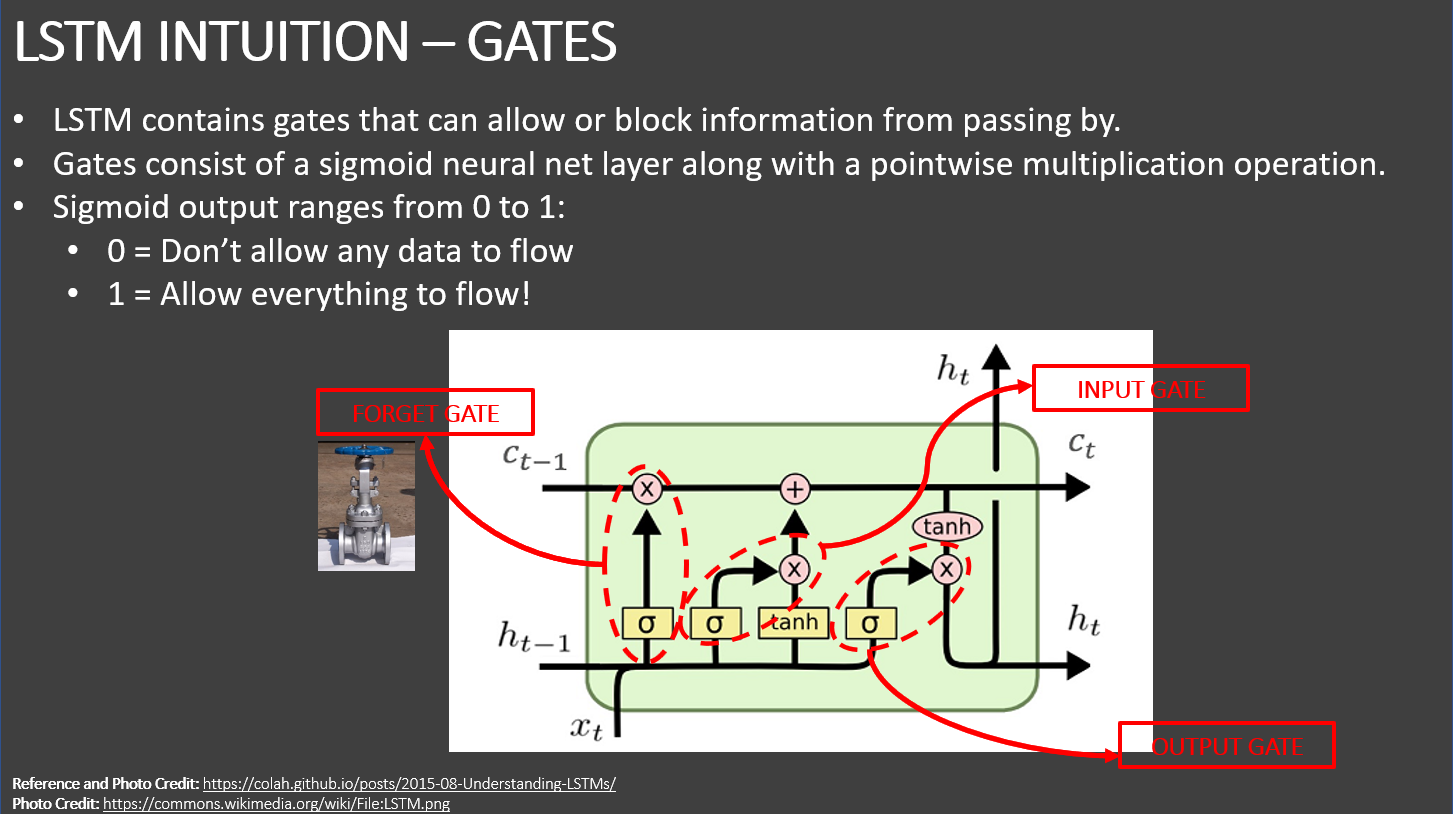

# BUILD AND TRAIN LSTM MODEL FOR PREDICTING GLOBAL TEMPERATURE TREND

In [ ]:
def create_model(train_x):
    # Create the model
    inputs = keras.layers.Input(shape = (train_x.shape[1], train_x.shape[2]))
    x = keras.layers.LSTM(50,return_sequences =  True)(inputs)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.LSTM(50, return_sequences = True)(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.LSTM(50)(x)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)

    model = keras.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer = 'adam', loss = "mse")
    return model

In [ ]:
model = create_model(train_x)
model.summary()

In [ ]:
# fit the network
history = model.fit(train_x, train_y, epochs = 50, batch_size = 72, validation_data = (test_x, test_y), shuffle = False)


In [ ]:
def plot_history(history):
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
plot_history(history)

#  ASSESS MODEL PERFORMANCE (GLOBAL DATA)

In [ ]:
def prediction(model,test_x,train_x, df):
    # Predict using the model
    predict =  model.predict(test_x)

    # Reshape test_x and train_x for visualization  and inverse-scaling purpose
    test_x = test_x.reshape((test_x.shape[0], test_x.shape[2]))
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[2]))

    # Concatenate test_x with predicted value
    predict_ = np.concatenate((test_x, predict),axis = 1)

    # Inverse-scaling to get the real values
    predict_ = scaler.inverse_transform(predict_)
    original_ = scaler.inverse_transform(test)

    # Create dataframe to store the predicted and original values
    pred = pd.DataFrame()
    pred['dt'] = df['dt'][-test_x.shape[0]:]
    pred['Original'] = original_[:,-1]
    pred['Predicted'] = predict_[:,-1]

    # Calculate the error 
    pred['Error'] = pred['Original'] - pred['Predicted']
    
    # Create dataframe for visualization
    df = df[['dt','AverageTemperature']][:-test_x.shape[0]]
    df.columns = ['dt','Original']
    original = df.append(pred[['dt','Original']])
    df.columns = ['dt','Predicted']
    predicted = df.append(pred[['dt','Predicted']])
    original = original.merge(predicted, left_on = 'dt',right_on = 'dt')
    return pred, original

In [ ]:
pred, original = prediction(model, test_x, train_x, df_global_monthly )

In [ ]:
def plot_error(df):

    # Plotting the Current and Predicted values
    fig = px.line(title = 'Prediction vs. Actual')
    fig.add_scatter(x = df['dt'], y = df['Original'], name = 'Original', opacity = 0.7)
    fig.add_scatter(x = df['dt'], y = df['Predicted'], name = 'Predicted', opacity = 0.5)
    fig.show()

    fig = px.line(title = 'Error')
    fig = fig.add_scatter(x = df['dt'], y = df['Error'])
    fig.show()



In [ ]:
def plot(df):
    # Plotting the Current and Predicted values
    fig = px.line(title = 'Prediction vs. Actual')
    fig.add_scatter(x = df['dt'], y = df['Original'], name = 'Original', opacity = 0.7)
    fig.add_scatter(x = df['dt'], y = df['Predicted'], name = 'Predicted', opacity = 0.5)
    fig.show()


In [ ]:
plot(original)

In [ ]:
plot_error(pred)

#  PREPARE THE DATA TO TRAIN THE MODEL (US DATA)

In [ ]:
# We are going to do the modeling for US data
US_df = temperature_df[temperature_df['Country'] == 'United States'].reset_index(drop = True)
US_df

In [ ]:
US_df = US_df.drop(['Country', 'year'], axis = 1)

In [ ]:
# Get the training data
US_df = prepare_data(US_df, 3)

In [ ]:
US_df

In [ ]:
US_df = US_df.dropna().reset_index(drop = True)

In [ ]:
# Split the data
train = US_df[:int(0.9 * len(US_df))].drop(columns = 'dt').values

In [ ]:
# Split the data
test = US_df[int(0.9 * len(US_df)):].drop(columns = 'dt').values

In [ ]:
train.shape

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range = (0, 1))
train  = scaler.fit_transform(train)
test   = scaler.transform(test)

# train  = scaler.fit_transform(train[:, 0:2])
# test   = scaler.transform(test[:,0:2])

In [ ]:
# Split the data into input features and targets
train_x, train_y = train[:,:-1], train[:,-1]
test_x, test_y = test[:,:-1], test[:,-1]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

In [ ]:
train_x

# BUILD AND TRAIN LSTM MODEL FOR PREDICTING US TEMPERATURE TREND (US DATA)

In [ ]:
model = create_model(train_x)
model.summary()

In [ ]:
# fit the network
history = model.fit(train_x, train_y, epochs = 50, batch_size = 72, validation_data = (test_x, test_y), shuffle = False)


In [ ]:
plot_history(history)

#  ASSESS MODEL PERFORMANCE (US DATA)

In [ ]:
pred, original = prediction(model, test_x, train_x, US_df )

In [ ]:
plot(original)

In [ ]:
plot_error(pred)

## END OF THE PROJECT